In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
%%writefile ../scripts/CreateVQs.py
import pickle as pk
import numpy as np
#from numpy import *
from glob import glob
from subprocess import Popen,PIPE
import sys
import traceback
from os import system
from os.path import isfile
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel,convolve

def run(command):
    print('cmd=',command)
    system(command)
    
def runPipe(command):
    print('runPipe cmd=',command)
    p=Popen(command.split(),stdout=PIPE,stderr=PIPE)
    L=p.communicate()
    stdout=L[0].decode("utf-8").split('\n')
    stderr=L[1].decode("utf-8").split('\n')
    return stdout,stderr

def clock(message):
    print('%8.1f \t%s'%(time(),message))
    time_log.append((time(),message))

def printClock():
    t=time_log[0][0]
    for i in range(1,len(time_log)):
        print('%8.1f \t%s'%(time_log[i][0]-t,time_log[i][1]))
        t=time_log[i][0]

def list_s3_files(stack_directory):
    stdout,stderr=runPipe("aws s3 ls %s/ "%(stack_directory))
    filenames=[]
    for line in stdout:
        parts=line.strip().split()
        if len(parts)!=4:
            continue
        filenames.append(parts[-1])
    return filenames

def read_files(s3_dir,_delete=False,data_dir='/dev/shm/data/'):
    s3files=list_s3_files(s3_dir)
    for filename in s3files:
        if not isfile(data_dir+'/'+filename):
            run('aws s3 cp %s/%s %s'%(s3_dir,filename,data_dir))
        D=fromfile(data_dir+'/'+filename,dtype=np.float16)
        pics=D.reshape([-1,_size,_size])
        if _delete:
            run('rm %s/%s'%(data_dir,filename))
        yield pics

def data_stream(s3_dir='s3://mousebraindata-open/MD657/permuted'):
    for pics in read_files(s3_dir):
        j=0
        for i in range(pics.shape[0]):
            if j%1000==0:
                print('\r examples read=%10d'%j,end='')
            j+=1    
            yield pics[i,:,:]

def calc_err(pic,gaussian = Gaussian2DKernel(1,x_size=7,y_size=7)):
    factor=sum(gaussian)
    P=convolve(pic,gaussian)/factor
    #except:
    #    print('err in calc_err/convolve',pic.shape,gaussian.shape,factor)
    #    P=pic
    error=sqrt(mean(abs(pic-P)))
    sub=P[::2,::2]
    return error,sub

def plot_patches(data,h=40,w=15,_titles=[]):
    figure(figsize=(w*2,h*2))
    for i in range(h*w):
        if i>=data.shape[0]:
            break
        subplot(h,w,i+1);
        pic=np.array(data[i,:,:],dtype=np.float32)

        fig=imshow(pic,cmap='gray')
        if(len(_titles)>i):
            plt.title(_titles[i])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

def pack_pics(Reps):
    size=Reps[0].shape[0]
    _len=len(Reps)
    Reps_mat=np.zeros([_len,size,size])
    for i in range(_len):
        Reps_mat[i,:,:]=Reps[i]
    return Reps_mat

def dist2(a,b):
    diff=(a-b)**2
    return sum(diff.flatten())

def dist_hist(data):
    D=[]
    for i in range(1,data.shape[0]):
        D.append(dist2(data[i,:,:],data[i-1,:,:]))
        if i%1000==0:
            print('\r',i,end='')
    hist(D,bins=100);

def refineKmeans(data_stream,Reps,per_rep_sample=100,refinement_iter=3):
    _shape=Reps[0].shape
    new_Reps=[np.zeros(_shape) for r in Reps]
    _area=_shape[0]*_shape[1]
    Reps_count=[0.0 for r in Reps]
    error=0
    count=per_rep_sample*len(Reps)
    i=0
    for patch in data_stream: 
        dists=[dist2(patch,r) for r in Reps]
        _argmin=argmin(dists)
        _min=min(dists)
        new_Reps[_argmin]+=patch
        Reps_count[_argmin]+=1
        error+=_min
        i+=1
        if i >= count:
            break
    error /= (count*_area)
    final_Reps=[]
    final_counts=[]
    for i in range(len(new_Reps)):
        if Reps_count[i]>refinement_iter:
            final_Reps.append(new_Reps[i]/Reps_count[i])
            final_counts.append(Reps_count[i])
    return final_Reps,final_counts,error

def Kmeans(data_stream,Reps=[],n=100):
    Reps,Statistics = Kmeanspp(data_stream,Reps,n)
    for i in range(5):
        Reps,final_counts,error = refineKmeans(data_stream,Reps)
        print('refine iteration %2d, error=%7.3f, n_Reps=%5d'%(i,error,len(Reps)))
    return Reps,final_counts

global scale
scale=550
def Kmeanspp(data_stream,Reps=[],n=100):
    global scale
    if len(Reps)==0:
        Reps=[next(data_stream)]

    Statistics=[]
    j=len(Reps)
    i=0
    for patch in data_stream: 
        _min=100000
        for r in Reps:
            _min=min(_min,dist2(patch,r))

        if _min>scale:
            scale*=1.5
            print('scale=',scale)

        Prob=_min/scale
        print('\r','i=%10d,  #reps=%10d  Prob=%8.6f'%(i,len(Reps),Prob),end='')
        i+=1
        Statistics.append((i,len(Reps),_min))
        if np.random.rand()<Prob:
            Reps.append(patch)
            j+=1
        if j>=n:
            break
    return Reps,Statistics

def plot_statistics(Statistics,alpha=0.05,_start=10): 
    N=[x[1] for x in Statistics]
    d=[x[2] for x in Statistics]

    s=mean(d[:_start])
    smoothed=[s]*_start
    for x in d[_start:]:
        s=(1-alpha)*s + alpha*x
        smoothed.append(s)
    loglog(N[_start:],smoothed[_start:])
    xlabel('N')
    ylabel('smoothed distance')
    grid(which='both')

def filtered_images(s3_dir='s3://mousebraindata-open/MD657/permuted',reduce_res=True,smooth_threshold=0.4):
    for pic in data_stream(s3_dir):
        err,sub=calc_err(pic)
        if err>smooth_threshold:
            continue
        if reduce_res:
            yield sub
        else:
            yield pic

if __name__=='__main__':

    _size=41
    gen=filtered_images(smooth_threshold=0.35,reduce_res=True)
    VQ={}
    for n in [10,100,500]:
        for c in range(10):
            print('========   n=%5d, c=%1d ==========='%(n,c))
            Reps,final_count=Kmeans(gen,n=n)
            VQ[(n,c)]=(Reps,final_count)

        #plot_patches(pack_pics(Reps),_titles=['n=%4d:#=%4d'%(n,x) for x in final_count])

    pk.dump(VQ,open('VQ5.pkl','wb'))


Writing ../scripts/CreateVQs.py


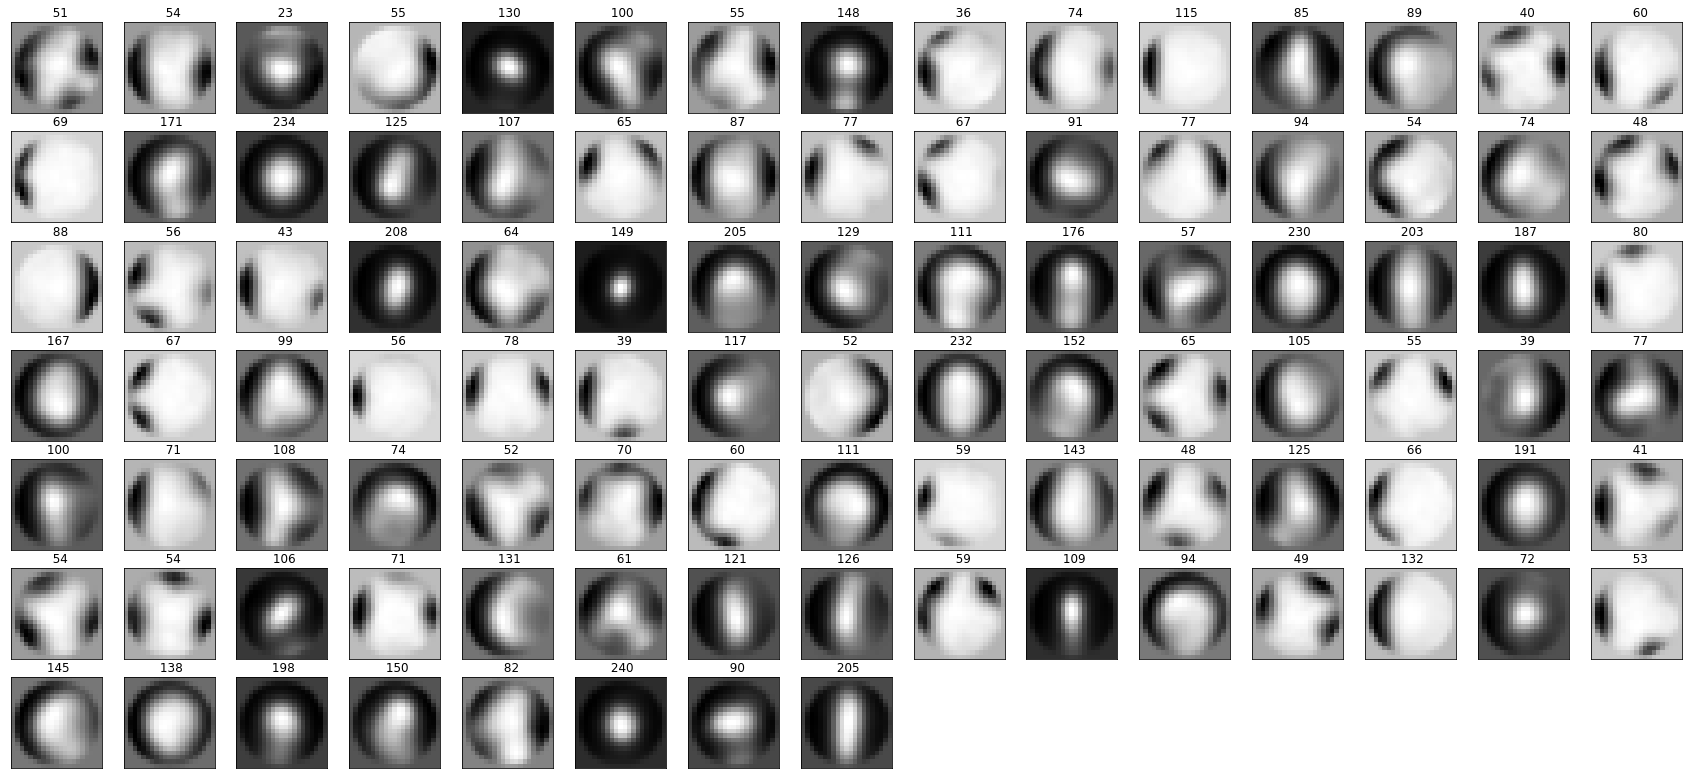

In [51]:
Reps,final_count=VQ[(100,0)]
plot_patches(pack_pics(Reps),_titles=['%4d'%x for x in final_count])

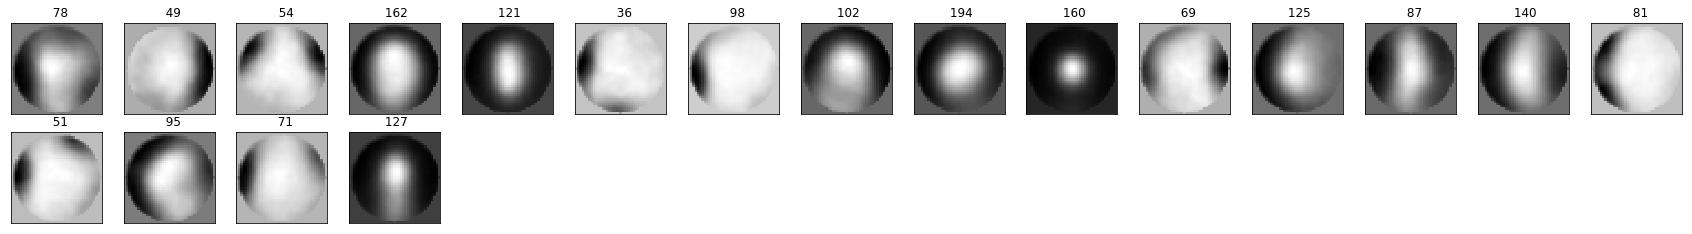

In [43]:
Reps,final_count=VQ[(20,1)]
plot_patches(pack_pics(Reps),_titles=['%4d'%x for x in final_count])

In [ ]:
Reps,final_count=Kmeans(gen,n=80)
plot_patches(pack_pics(Reps),_titles=['%4d'%x for x in final_count])

In [ ]:
Reps,final_count=Kmeans(gen,Reps=[],n=160)
plot_patches(pack_pics(Reps),_titles=['%4d'%x for x in final_count])

In [ ]:
Reps,final_count=Kmeans(gen,Reps=[],n=320)
plot_patches(pack_pics(Reps),_titles=['%4d'%x for x in final_count])

In [ ]:
g=filtered_images()
for i in range(10):
    pic=next(g)
    print(pic.shape,pic[10,10])

In [ ]:
#if __name__=="__main__"
N=300

Reps, Statistics = Kmeanspp(lcombined,n=N)
Reps_mat = pack_pics(Reps)
plot_patches(Reps_mat,h=5,w=10)

In [ ]:
for i in range(1,4):
    new_Reps,Reps_count,error = refineKmeans(lcombined[i*10000:(i+1)*10000,:,:],Reps)
    print(i,error,len(Reps_count))
    Reps_mat = pack_pics(new_Reps)
    plot_patches(Reps_mat,h=1,w=10,_titles=['%4d'%x for x in Reps_count])
    Reps=new_Reps
plot_patches(Reps_mat,h=10,w=10,_titles=['final_%4d'%x for x in Reps_count])

In [ ]:
%pylab inline

In [ ]:
imshow(pic)